In [1]:
# https://www.kaggle.com/code/ekhosravi/yolov3-mehr

import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import add 
from keras.models import Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Returns a list of class names read from `file_name`
def load_class_names(file_name):
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names

In [3]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x

def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,	= struct.unpack('i', w_f.read(4))
            minor,	= struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')

    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0


In [4]:
# define the model
model = make_yolov3_model()

# load the model weights
weight_reader = WeightReader('/kaggle/input/yolov3-weights/yolov3.weights')

# set the model weights into the model
weight_reader.load_weights(model)

# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [5]:
# load yolov3 model and perform object detection 
from numpy import expand_dims
from keras.models import load_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    
    # convert to numpy array
    image = img_to_array(image)
    
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [6]:
# load yolov3 model and perform object detection
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    
    # convert to numpy array
    image = img_to_array(image)
    
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    
    # plot the image
    pyplot.imshow(data)
    
    # get the context for drawing boxes
    ax = pyplot.gca()
    pyplot
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='blue')
        
        # draw the box
        ax.add_patch(rect)

        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='red')
        pyplot.axis('off')


    # show the plot
    pyplot.show()

In [7]:
def ShowBoxes_For_Input_Imgs(model, class_names, filename):

    # define the expected input shape for the model
    input_w, input_h = 416, 416

    # define our new photo
    photo_filename = filename

    # load and prepare image
    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

    # make prediction
    yhat = model.predict(image)

    # summarize the shape of the list of arrays
    print([a.shape for a in yhat])

    # define the anchors
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

    # define the probability threshold for detected objects
    class_threshold = 0.6
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

    # suppress non-maximal boxes
    do_nms(boxes, 0.5)

    # define the labels
    labels = class_names # load_class_names('/kaggle/input/coconame/coco.names')

    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

    # summarize what we found
    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])

    # draw what we found
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [8]:
# load yolov3 model
model = load_model('model.h5')
# define the labels
labels = load_class_names('/kaggle/input/coconame/coco.names')

1/1 [==============================] - 9s 9s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
zebra 97.9082465171814
zebra 99.68568682670593
zebra 98.6544132232666


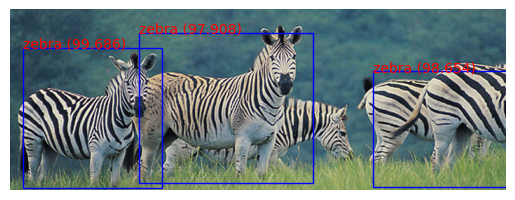

In [9]:
ShowBoxes_For_Input_Imgs(model, labels, '/kaggle/input/zebra-img/zebra.jpg')

1/1 [==============================] - 0s 29ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.92944002151489
chair 65.34187197685242
person 98.3036994934082
person 90.85548520088196
person 99.74668025970459
person 98.33798408508301
tvmonitor 80.54275512695312
chair 96.66080474853516
laptop 66.35971665382385
keyboard 76.1238694190979
keyboard 82.65663981437683
tvmonitor 61.85231804847717
tvmonitor 84.55656170845032
tvmonitor 70.99801301956177
tvmonitor 84.58911180496216
tvmonitor 87.78020739555359


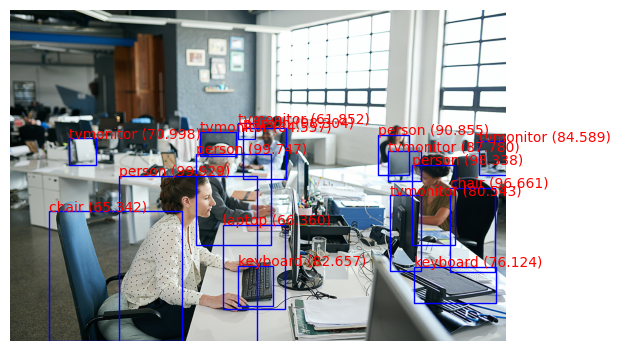

In [10]:
ShowBoxes_For_Input_Imgs(model, labels, '/kaggle/input/office/office.jpg')

1/1 [==============================] - 0s 28ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
car 94.87224221229553
car 95.53848505020142
car 96.35396003723145
car 92.20682978630066
car 89.89726305007935
car 97.11308479309082
car 98.14634919166565
car 94.33169960975647
car 88.82631063461304
car 93.34834218025208


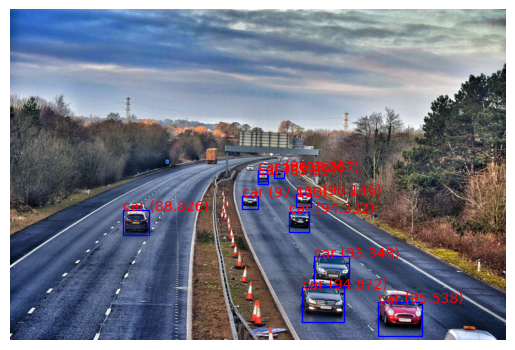

In [11]:
ShowBoxes_For_Input_Imgs(model, labels, '/kaggle/input/inpputcars/cars.jpg')

In [12]:
import numpy as np
import pandas as pd
import cv2, os, glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add, Concatenate, Conv2D,
    Input, Lambda, LeakyReLU,
    MaxPool2D, UpSampling2D, ZeroPadding2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)
from tensorflow.keras.utils import plot_model

In [13]:
# Returns a list of class names read from `file_name`
def load_class_names(file_name):
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names

In [14]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]
 
yolo_anchors = np.array([
    (10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
    (59, 119), (116, 90), (156, 198), (373, 326)],
    np.float32) / 416

yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

class_names = load_class_names('/kaggle/input/coconame/coco.names')

In [15]:
def load_darknet_weights(model, weights_file):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    layers = YOLOV3_LAYER_LIST
    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]
            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]
            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(wf, dtype=np.float32, count=4 * filters)
                
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
                
            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
            
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])
            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)
                
    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

In [16]:
def broadcast_iou(box_1, box_2):
    '''
    box_1: (..., (x1, y1, x2, y2))
    box_2: (N, (x1, y1, x2, y2))
    '''
    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)
    
    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) - tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) - tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)

In [17]:
def freeze_all(model, frozen = True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

In [18]:
def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
                                                class_names[int(classes[i])], objectness[i]),
                                                x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

In [19]:
def draw_labels(x, y, class_names):
    img = x.numpy()
    boxes, classes = tf.split(y, (4, 1), axis = -1)
    classes = classes[..., 0]
    wh = np.flip(img.shape[0 : 2])
    for i in range(len(boxes)):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(
                        img, class_names[classes[i]],
                        x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        8, (0, 0, 255), 2
        )
    return img

In [20]:
def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train

In [21]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):
    N = tf.shape(y_true)[0]
    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))
    anchor_idxs = tf.cast(anchor_idxs, tf.int32)
    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))
            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2
                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1
    return tf.tensor_scatter_nd_update(y_true_out, indexes.stack(), updates.stack())

In [22]:
def transform_targets(y_train, anchors, anchor_masks, classes):
    y_outs = []
    grid_size = 13
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2), (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)
    y_train = tf.concat([y_train, anchor_idx], axis=-1)
    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs, classes))
        grid_size *= 2
    return tuple(y_outs)

## YOLO V3 Model

In [23]:
class BatchNormalization(tf.keras.layers.BatchNormalization):

    def call(self, x, training = False):
        if training is None:
            traininig = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

In [24]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x

def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x

def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)


In [25]:
def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs
            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

def yolo_boxes(pred, anchors, classes):
    '''pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))'''
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)
    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors
    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    return bbox, objectness, class_probs, pred_box

def yolo_nms(outputs, anchors, masks, classes):
    '''boxes, conf, type'''
    b, c, t = [], [], []
    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))
    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)
    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores,
            (tf.shape(scores)[0], -1, tf.shape(scores)[-1])
        ),
        max_output_size_per_class=100,
        max_total_size = 100,
        iou_threshold = 0.5,
        score_threshold = 0.5
    )
    return boxes, scores, classes, valid_detections

In [26]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors, masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels])
    x_36, x_61, x = Darknet(name='yolo_darknet')(x)
    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)
    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)
    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)
    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes), name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes), name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes), name='yolo_boxes_2')(output_2)
    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes), name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))
    return Model(inputs, outputs, name='yolov3')


## YOLO Loss

In [27]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]
        
        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]
        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]
        
        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh), tf.zeros_like(true_wh), true_wh)
        
        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(broadcast_iou(pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)
        
        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + (1 - obj_mask) * ignore_mask * obj_loss
        # Could also use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(true_class_idx, pred_class)
        
        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))
        return xy_loss + wh_loss + obj_loss + class_loss
    
    return yolo_loss

In [28]:
yolo = YoloV3(classes = 80)
yolo.summary()

Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 yolo_darknet (Functional)      ((None, None, None,  40620640    ['input_2[0][0]']                
                                 256),                                                            
                                 (None, None, None,                                               
                                 512),                                                            
                                 (None, None, None,                                          

In [29]:
load_darknet_weights(yolo, '/kaggle/input/yolov3-weights/yolov3.weights')

In [30]:
def predict_OD(image_file, visualize = True, figsize = (16, 16)):
    img = tf.image.decode_image(open(image_file, 'rb').read(), channels=3)
    img = tf.expand_dims(img, 0)
    img = transform_images(img, 416)
    boxes, scores, classes, nums = yolo.predict(img)
    img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    if visualize:
        fig, axes = plt.subplots(figsize = figsize)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    return boxes, scores, classes, nums

In [31]:
image_file = glob.glob('/kaggle/input/coco-2017-dataset/coco2017/test2017/*')
len(image_file)

40670

1/1 [==============================] - 2s 2s/step


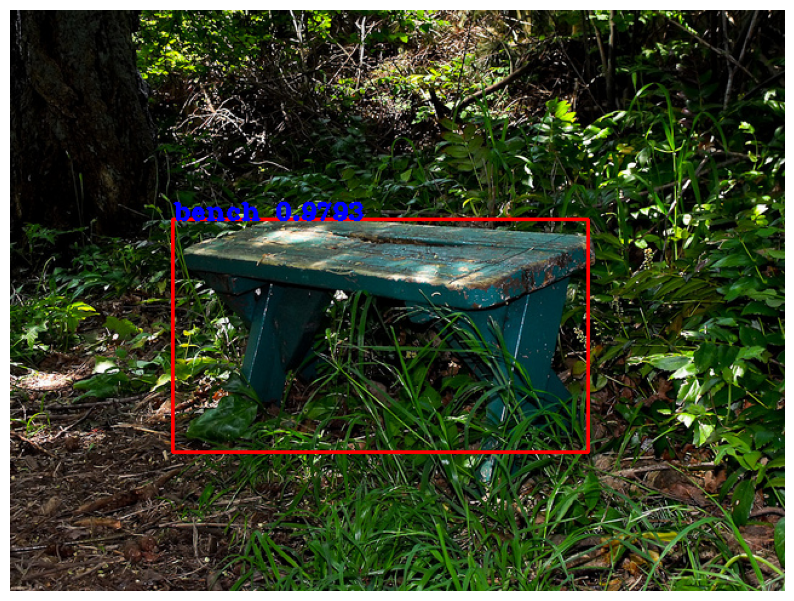

In [32]:
boxes, scores, classes, nums = predict_OD(image_file[0], figsize = (10,10))

In [33]:
scores

array([[0.97928315, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [34]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from seaborn import color_palette
import cv2

In [35]:
_BATCH_NORM_DECAY = 0.9
_BATCH_NORM_EPSILON = 1e-05
_LEAKY_RELU = 0.1
_ANCHORS = [(10, 13), (16, 30), (33, 23),
            (30, 61), (62, 45), (59, 119),
            (116, 90), (156, 198), (373, 326)]
_MODEL_SIZE = (416, 416)
_Lin_SIZE = 416

In [36]:
def batch_norm(inputs, training, data_format):
    """Performs a batch normalization using a standard set of parameters."""
    return tf.compat.v1.layers.batch_normalization(
        inputs=inputs, axis=1 if data_format == 'channels_first' else 3,
        momentum=_BATCH_NORM_DECAY, epsilon=_BATCH_NORM_EPSILON,
        scale=True, training=training)


def fixed_padding(inputs, kernel_size, data_format):
 
    pad_total = kernel_size - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg

    if data_format == 'channels_first':
        padded_inputs = tf.pad(inputs, [[0, 0], [0, 0],
                                        [pad_beg, pad_end],
                                        [pad_beg, pad_end]])
    else:
        padded_inputs = tf.pad(inputs, [[0, 0], [pad_beg, pad_end],
                                        [pad_beg, pad_end], [0, 0]])
    return padded_inputs


def conv2d_fixed_padding(inputs, filters, kernel_size, data_format, strides=1):
    """Strided 2-D convolution with explicit padding."""
    if strides > 1:
        inputs = fixed_padding(inputs, kernel_size, data_format)

    return  tf.compat.v1.layers.conv2d(
        inputs=inputs, filters=filters, kernel_size=kernel_size,
        strides=strides, padding=('SAME' if strides == 1 else 'VALID'),
        use_bias=False, data_format=data_format)

In [37]:
def darknet53_residual_block(inputs, filters, training, data_format, strides=1):
    """Creates a residual block for Darknet."""
    shortcut = inputs

    inputs = conv2d_fixed_padding(
        inputs, filters=filters, kernel_size=1, strides=strides,
        data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(
        inputs, filters=2 * filters, kernel_size=3, strides=strides,
        data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs += shortcut

    return inputs


def darknet53(inputs, training, data_format):
    """Creates Darknet53 model for feature extraction."""
    inputs = conv2d_fixed_padding(inputs, filters=32, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
    inputs = conv2d_fixed_padding(inputs, filters=64, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = darknet53_residual_block(inputs, filters=32, training=training,
                                      data_format=data_format)

    inputs = conv2d_fixed_padding(inputs, filters=128, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(2):
        inputs = darknet53_residual_block(inputs, filters=64,
                                          training=training,
                                          data_format=data_format)

    inputs = conv2d_fixed_padding(inputs, filters=256, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(8):
        inputs = darknet53_residual_block(inputs, filters=128,
                                          training=training,
                                          data_format=data_format)

    route1 = inputs

    inputs = conv2d_fixed_padding(inputs, filters=512, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(8):
        inputs = darknet53_residual_block(inputs, filters=256,
                                          training=training,
                                          data_format=data_format)

    route2 = inputs

    inputs = conv2d_fixed_padding(inputs, filters=1024, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(4):
        inputs = darknet53_residual_block(inputs, filters=512,
                                          training=training,
                                          data_format=data_format)

    return route1, route2, inputs

In [38]:
def yolo_convolution_block(inputs, filters, training, data_format):
    """Creates convolution operations layer used after Darknet."""
    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    route = inputs

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    return route, inputs

In [39]:
def yolo_layer(inputs, n_classes, anchors, img_size, data_format):
    
    n_anchors = len(anchors)

    inputs = tf.compat.v1.layers.conv2d(inputs, filters=n_anchors * (5 + n_classes),
                              kernel_size=1, strides=1, use_bias=True,
                              data_format=data_format)

    shape = inputs.get_shape().as_list()
    grid_shape = shape[2:4] if data_format == 'channels_first' else shape[1:3]
    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 2, 3, 1])
    inputs = tf.reshape(inputs, [-1, n_anchors * grid_shape[0] * grid_shape[1],
                                 5 + n_classes])

    strides = (img_size[0] // grid_shape[0], img_size[1] // grid_shape[1])

    box_centers, box_shapes, confidence, classes = \
        tf.split(inputs, [2, 2, 1, n_classes], axis=-1)

    x = tf.range(grid_shape[0], dtype=tf.float32)
    y = tf.range(grid_shape[1], dtype=tf.float32)
    x_offset, y_offset = tf.meshgrid(x, y)
    x_offset = tf.reshape(x_offset, (-1, 1))
    y_offset = tf.reshape(y_offset, (-1, 1))
    x_y_offset = tf.concat([x_offset, y_offset], axis=-1)
    x_y_offset = tf.tile(x_y_offset, [1, n_anchors])
    x_y_offset = tf.reshape(x_y_offset, [1, -1, 2])
    box_centers = tf.nn.sigmoid(box_centers)
    box_centers = (box_centers + x_y_offset) * strides

    anchors = tf.tile(anchors, [grid_shape[0] * grid_shape[1], 1])
    box_shapes = tf.exp(box_shapes) * tf.cast(anchors, tf.float32)

    confidence = tf.nn.sigmoid(confidence)

    classes = tf.nn.sigmoid(classes)

    inputs = tf.concat([box_centers, box_shapes,
                        confidence, classes], axis=-1)

    return inputs

In [40]:
def upsample(inputs, out_shape, data_format):
    """Upsamples to `out_shape` using nearest neighbor interpolation."""
    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 2, 3, 1])
        new_height = out_shape[3]
        new_width = out_shape[2]
    else:
        new_height = out_shape[2]
        new_width = out_shape[1]

    #inputs = tf.image.resize_nearest_neighbor(inputs, (new_height, new_width))
    inputs = tf.image.resize(inputs, (new_height, new_width), method='nearest')

    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 3, 1, 2])

    return inputs

In [41]:
def build_boxes(inputs):
    """Computes top left and bottom right points of the boxes."""
    center_x, center_y, width, height, confidence, classes = \
        tf.split(inputs, [1, 1, 1, 1, 1, -1], axis=-1)

    top_left_x = center_x - width / 2
    top_left_y = center_y - height / 2
    bottom_right_x = center_x + width / 2
    bottom_right_y = center_y + height / 2

    boxes = tf.concat([top_left_x, top_left_y,
                       bottom_right_x, bottom_right_y,
                       confidence, classes], axis=-1)

    return boxes


def non_max_suppression(inputs, n_classes, max_output_size, iou_threshold,
                        confidence_threshold):
   
    batch = tf.unstack(inputs)
    boxes_dicts = []
    for boxes in batch:
        boxes = tf.boolean_mask(boxes, boxes[:, 4] > confidence_threshold)
        classes = tf.argmax(boxes[:, 5:], axis=-1)
        classes = tf.expand_dims(tf.cast(classes, tf.float32), axis=-1)
        boxes = tf.concat([boxes[:, :5], classes], axis=-1)

        boxes_dict = dict()
        for cls in range(n_classes):
            mask = tf.equal(boxes[:, 5], cls)
            mask_shape = mask.get_shape()
            if mask_shape.ndims != 0:
                class_boxes = tf.boolean_mask(boxes, mask)
                boxes_coords, boxes_conf_scores, _ = tf.split(class_boxes,
                                                              [4, 1, -1],
                                                              axis=-1)
                boxes_conf_scores = tf.reshape(boxes_conf_scores, [-1])
                indices = tf.image.non_max_suppression(boxes_coords,
                                                       boxes_conf_scores,
                                                       max_output_size,
                                                       iou_threshold)
                class_boxes = tf.gather(class_boxes, indices)
                boxes_dict[cls] = class_boxes[:, :5]

        boxes_dicts.append(boxes_dict)

    return boxes_dicts

In [42]:
class Yolo_v3:
    """Yolo v3 model class."""

    def __init__(self, n_classes, model_size, max_output_size, iou_threshold,
                 confidence_threshold, data_format=None):
        """Creates the model.
        """
        if not data_format:
            if tf.test.is_built_with_cuda():
                data_format = 'channels_first'
            else:
                data_format = 'channels_last'

        self.n_classes = n_classes
        self.model_size = model_size
        self.max_output_size = max_output_size
        self.iou_threshold = iou_threshold
        self.confidence_threshold = confidence_threshold
        self.data_format = data_format

    def __call__(self, inputs, training):
        
        with tf.compat.v1.variable_scope('yolo_v3_model'):
            if self.data_format == 'channels_first':
                inputs = tf.transpose(inputs, [0, 3, 1, 2])

            inputs = inputs / 255

            route1, route2, inputs = darknet53(inputs, training=training,
                                               data_format=self.data_format)

            route, inputs = yolo_convolution_block(
                inputs, filters=512, training=training,
                data_format=self.data_format)
            detect1 = yolo_layer(inputs, n_classes=self.n_classes,
                                 anchors=_ANCHORS[6:9],
                                 img_size=self.model_size,
                                 data_format=self.data_format)

            inputs = conv2d_fixed_padding(route, filters=256, kernel_size=1,
                                          data_format=self.data_format)
            inputs = batch_norm(inputs, training=training,
                                data_format=self.data_format)
            inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
            upsample_size = route2.get_shape().as_list()
            inputs = upsample(inputs, out_shape=upsample_size,
                              data_format=self.data_format)
            axis = 1 if self.data_format == 'channels_first' else 3
            inputs = tf.concat([inputs, route2], axis=axis)
            route, inputs = yolo_convolution_block(
                inputs, filters=256, training=training,
                data_format=self.data_format)
            detect2 = yolo_layer(inputs, n_classes=self.n_classes,
                                 anchors=_ANCHORS[3:6],
                                 img_size=self.model_size,
                                 data_format=self.data_format)

            inputs = conv2d_fixed_padding(route, filters=128, kernel_size=1,
                                          data_format=self.data_format)
            inputs = batch_norm(inputs, training=training,
                                data_format=self.data_format)
            inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
            upsample_size = route1.get_shape().as_list()
            inputs = upsample(inputs, out_shape=upsample_size,
                              data_format=self.data_format)
            inputs = tf.concat([inputs, route1], axis=axis)
            route, inputs = yolo_convolution_block(
                inputs, filters=128, training=training,
                data_format=self.data_format)
            detect3 = yolo_layer(inputs, n_classes=self.n_classes,
                                 anchors=_ANCHORS[0:3],
                                 img_size=self.model_size,
                                 data_format=self.data_format)

            inputs = tf.concat([detect1, detect2, detect3], axis=1)

            inputs = build_boxes(inputs)

            boxes_dicts = non_max_suppression(
                inputs, n_classes=self.n_classes,
                max_output_size=self.max_output_size,
                iou_threshold=self.iou_threshold,
                confidence_threshold=self.confidence_threshold)

            return boxes_dicts

In [43]:
def load_images(img_names, model_size):
    imgs = []

    for img_name in img_names:
        img = Image.open(img_name)
        img = img.resize(size=model_size)
        img = np.array(img, dtype=np.float32)
        img = np.expand_dims(img, axis=0)
        imgs.append(img)

    imgs = np.concatenate(imgs)

    return imgs


def load_class_names(file_name):
    """Returns a list of class names read from `file_name`."""
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names


def draw_boxes(img_names, boxes_dicts, class_names, model_size):
    colors = ((np.array(color_palette("hls", 80)) * 255)).astype(np.uint8)
    for num, img_name, boxes_dict in zip(range(len(img_names)), img_names, boxes_dicts):
        img = Image.open(img_name)
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype(font='/kaggle/input/fontfuture/futur.ttf', size=(img.size[0] + img.size[1]) // 100)
        resize_factor = (img.size[0] / model_size[0], img.size[1] / model_size[1])
        for cls in range(len(class_names)):
            boxes = boxes_dict[cls]
            if np.size(boxes) != 0:
                color = colors[cls]
                for box in boxes:
                    xy, confidence = box[:4], box[4]
                    xy = [xy[i] * resize_factor[i % 2] for i in range(4)]
                    x0, y0 = xy[0], xy[1]
                    thickness = (img.size[0] + img.size[1]) // 200
                    for t in np.linspace(0, 1, thickness):
                        xy[0], xy[1] = xy[0] + t, xy[1] + t
                        xy[2], xy[3] = xy[2] - t, xy[3] - t
                        draw.rectangle(xy, outline=tuple(color))
                    text = '{} {:.1f}%'.format(class_names[cls], confidence * 100)
                    text_size = draw.textsize(text, font=font)
                    draw.rectangle([x0, y0 - text_size[1], x0 + text_size[0], y0], fill=tuple(color))
                    draw.text((x0, y0 - text_size[1]), text, fill='black', font=font)

        display(img)

In [44]:
def load_weights(variables, file_name):

    with open(file_name, "rb") as f:
        # Skip first 5 values containing irrelevant info
        np.fromfile(f, dtype=np.int32, count=5)
        weights = np.fromfile(f, dtype=np.float32)

        assign_ops = []
        ptr = 0

        # Load weights for Darknet part.
        # Each convolution layer has batch normalization.
        for i in range(52):
            conv_var = variables[5 * i]
            gamma, beta, mean, variance = variables[5 * i + 1:5 * i + 5]
            batch_norm_vars = [beta, gamma, mean, variance]

            for var in batch_norm_vars:
                shape = var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(shape)
                ptr += num_params
                assign_ops.append(tf.compat.v1.assign(var, var_weights))

            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.compat.v1.assign(conv_var, var_weights))

        # Loading weights for Yolo part.
        # 7th, 15th and 23rd convolution layer has biases and no batch norm.
        ranges = [range(0, 6), range(6, 13), range(13, 20)]
        unnormalized = [6, 13, 20]
        for j in range(3):
            for i in ranges[j]:
                current = 52 * 5 + 5 * i + j * 2
                conv_var = variables[current]
                gamma, beta, mean, variance =  \
                    variables[current + 1:current + 5]
                batch_norm_vars = [beta, gamma, mean, variance]

                for var in batch_norm_vars:
                    shape = var.shape.as_list()
                    num_params = np.prod(shape)
                    var_weights = weights[ptr:ptr + num_params].reshape(shape)
                    ptr += num_params
                    assign_ops.append(tf.compat.v1.assign(var, var_weights))

                shape = conv_var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(
                    (shape[3], shape[2], shape[0], shape[1]))
                var_weights = np.transpose(var_weights, (2, 3, 1, 0))
                ptr += num_params
                assign_ops.append(tf.compat.v1.assign(conv_var, var_weights))

            bias = variables[52 * 5 + unnormalized[j] * 5 + j * 2 + 1]
            shape = bias.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(shape)
            ptr += num_params
            assign_ops.append(tf.compat.v1.assign(bias, var_weights))

            conv_var = variables[52 * 5 + unnormalized[j] * 5 + j * 2]
            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.compat.v1.assign(conv_var, var_weights))

    return assign_ops

In [45]:
img_names = ['/kaggle/input/inpputcars/cars.jpg', '/kaggle/input/zebra-img/zebra.jpg']


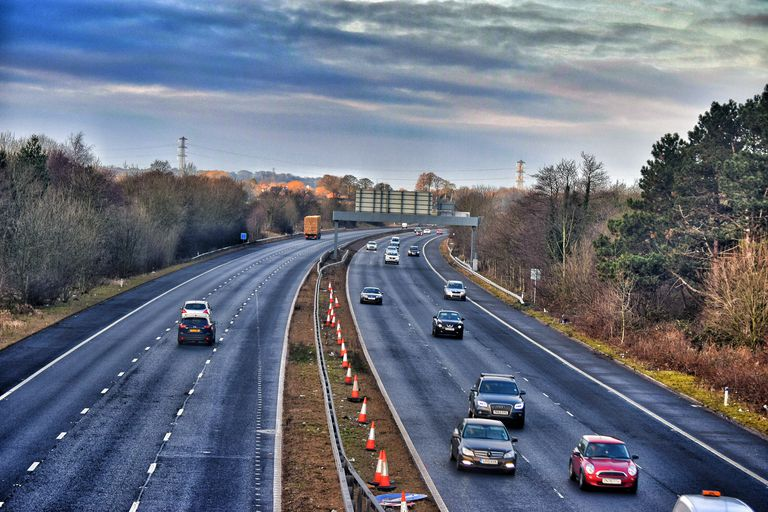

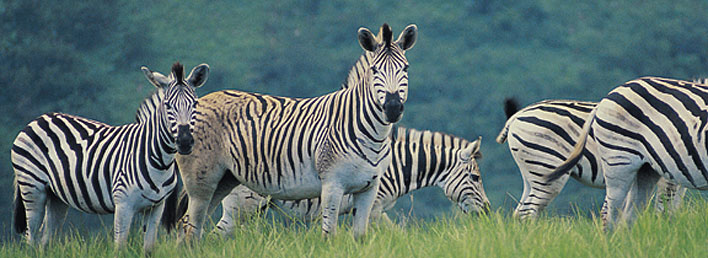

In [46]:
for img in img_names: display(Image.open(img))

/tmp/ipykernel_28/2244925443.py:30: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  return  tf.compat.v1.layers.conv2d(
/tmp/ipykernel_28/2244925443.py:3: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  return tf.compat.v1.layers.batch_normalization(
/tmp/ipykernel_28/2403152453.py:5: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  inputs = tf.compat.v1.layers.conv2d(inputs, filters=n_anchors * (5 + n_classes),
/tmp/ipykernel_28/342803593.py:44: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength

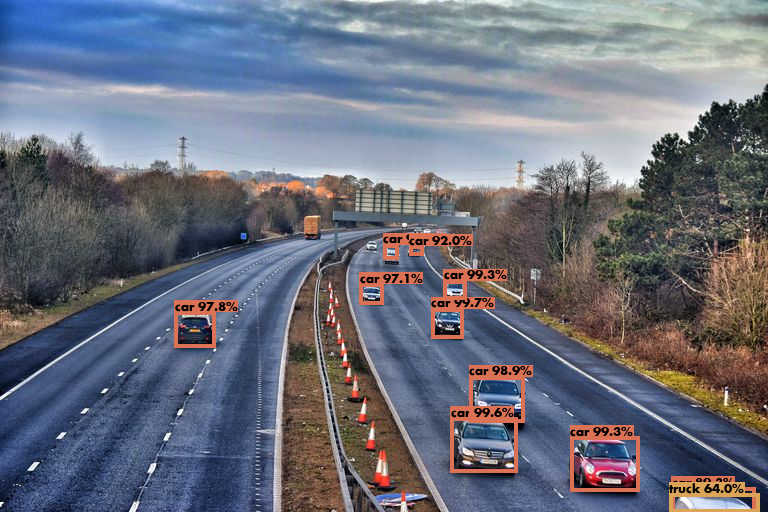

/tmp/ipykernel_28/342803593.py:44: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_28/342803593.py:44: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
/tmp/ipykernel_28/342803593.py:44: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)


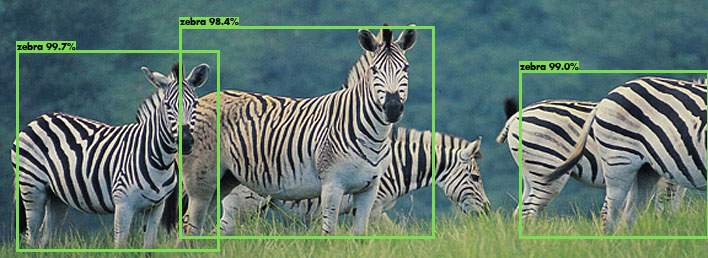

In [47]:
batch_size = len(img_names)
batch = load_images(img_names, model_size=_MODEL_SIZE)
class_names = load_class_names('/kaggle/input/coconame/coco.names')
n_classes = len(class_names)
max_output_size = 10
iou_threshold = 0.5
confidence_threshold = 0.5

model = Yolo_v3(n_classes=n_classes, model_size=_MODEL_SIZE,
                max_output_size=max_output_size,
                iou_threshold=iou_threshold,
                confidence_threshold=confidence_threshold)

tf.compat.v1.disable_eager_execution()
inputs =  tf.compat.v1.placeholder(tf.float32, [batch_size, 416, 416, 3])

detections = model(inputs, training=False)

model_vars = tf.compat.v1.global_variables(scope='yolo_v3_model')
assign_ops = load_weights(model_vars, '/kaggle/input/yolov3-weights/yolov3.weights')

with tf.compat.v1.Session() as sess:
    sess.run(assign_ops)
    detection_result = sess.run(detections, feed_dict={inputs: batch})
    
draw_boxes(img_names, detection_result, class_names, _MODEL_SIZE)

In [48]:
import numpy as np
import pandas as pd 
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset,DataLoader
import albumentations as A
import torch.optim as optim
import warnings

warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Data prepare

In [49]:
csv_path = '/kaggle/input/voc-2012csv/voc-2012.csv'
df = pd.read_csv(csv_path)
df.head()

filename                                               name  \
0  2011_006424.jpg                                         ['person']   
1  2010_003717.jpg                                 ['sofa', 'bottle']   
2  2009_000488.jpg                ['tvmonitor', 'cat', 'pottedplant']   
3  2008_001218.jpg                                          ['horse']   
4  2009_003138.jpg  ['car', 'car', 'car', 'car', 'car', 'car', 'ca...   

                                                 box  
0                               [[67, 56, 269, 369]]  
1          [[34, 1, 498, 242], [432, 305, 500, 332]]  
2  [[21, 1, 193, 95], [224, 159, 287, 229], [341,...  
3                                 [[1, 1, 375, 500]]  
4  [[466, 137, 500, 176], [395, 141, 481, 189], [...

In [50]:
name_class = []
for name in df['name']:
    for n in eval(name):  # 将str转为list
        name_class.append(n)
name_class = sorted(list(set(name_class)))
print(len(name_class),type(name_class))
name_class

20 <class 'list'>


['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [51]:
class_to_idx = {}
idx_to_class = {}
for idx,classes in enumerate(name_class):
    class_to_idx[classes] = idx
    idx_to_class[idx] = classes
    
print(type(class_to_idx))
class_to_idx

<class 'dict'>


{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [52]:
def name_to_idx(name):
    idx = []
    for n in eval(name):
        idx.append(class_to_idx[n])
    return idx

df['name_to_idx'] = df.name.apply(lambda x:name_to_idx(x))
df.head()

filename                                               name  \
0  2011_006424.jpg                                         ['person']   
1  2010_003717.jpg                                 ['sofa', 'bottle']   
2  2009_000488.jpg                ['tvmonitor', 'cat', 'pottedplant']   
3  2008_001218.jpg                                          ['horse']   
4  2009_003138.jpg  ['car', 'car', 'car', 'car', 'car', 'car', 'ca...   

                                                 box  \
0                               [[67, 56, 269, 369]]   
1          [[34, 1, 498, 242], [432, 305, 500, 332]]   
2  [[21, 1, 193, 95], [224, 159, 287, 229], [341,...   
3                                 [[1, 1, 375, 500]]   
4  [[466, 137, 500, 176], [395, 141, 481, 189], [...   

                   name_to_idx  
0                         [14]  
1                      [17, 4]  
2                  [19, 7, 15]  
3                         [12]  
4  [6, 6, 6, 6, 6, 6, 6, 6, 6]

In [53]:
l = len(df)
df_trainval = df[:int(l*0.8)]
df_train = df_trainval[:int(l*0.8*0.8)]
df_val = df_trainval[int(l*0.8*0.8):]
df_test = df[int(l*0.8):]
print(df_train.shape,df_val.shape,df_test.shape)

(10960, 4) (2740, 4) (3425, 4)


In [54]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## Make dataset by Dataset Module

In [55]:
transform_train = A.Compose([
        A.Resize(width=416, height=416, p=1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
    ], 
    bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

transform_val = A.Compose([
        A.Resize(width=416, height=416, p=1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
    ], 
    bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

transform_test = A.Compose([

    ], 
    bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

In [56]:
Img_root = '/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages'
class VOCDataset(Dataset):
    def __init__(self, dataframe, transforms=None):
        super().__init__()

        self.filename = dataframe['filename']
        self.box = dataframe['box']
        self.label = dataframe['name_to_idx']
        self.transforms = transforms
        
    def __len__(self) -> int:
        return self.filename.shape[0]
    
    def __getitem__(self, index: int):
        file_path = os.path.join(Img_root,self.filename[index])
        
        image = cv2.imread(file_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = np.array(eval(self.box[index]))
        labels = np.array(self.label[index])
        
        target = {}
        target['box'] = boxes
        target['label'] = labels
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['box'],
                'labels': target['label']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['box'] = sample['bboxes']
        return image, target

image_size = (416,416)
# DataLoader
def yolo_dataset_collate(batch):
    images = []
    bboxes = []
    for img, target in batch:
        images.append(img.transpose(2,0,1))
        boxes = np.array(target['box']).astype(np.float32)
        labels = np.array(target['label'])
        if len(boxes) != 0:
            boxes[:, [0, 2]] = boxes[:, [0, 2]] / image_size[0]
            boxes[:, [1, 3]] = boxes[:, [1, 3]] / image_size[1]

            boxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]
            boxes[:, 0:2] = boxes[:, 0:2] + boxes[:, 2:4] / 2
            t = []
            for box,label in zip(boxes,labels):
                box = np.append(box,label)
                t.append(box)
            bboxes.append(np.array(t))
    images = torch.from_numpy(np.array(images)).type(torch.FloatTensor)
    bboxes = [torch.from_numpy(ann).type(torch.FloatTensor) for ann in bboxes]
    return images, bboxes

In [57]:
train_ds = VOCDataset(df_train,transform_train)
val_ds = VOCDataset(df_val,transform_val)
test_ds = VOCDataset(df_test,transform_test)

train_dl = DataLoader(train_ds,batch_size=4,num_workers=2,collate_fn=yolo_dataset_collate,
                      shuffle=True,pin_memory=True,drop_last=True)
val_dl = DataLoader(val_ds,batch_size=4,num_workers=2,collate_fn=yolo_dataset_collate,
                    shuffle=False,pin_memory=True,drop_last=True)
test_dl = DataLoader(test_ds,batch_size=4,num_workers=2,collate_fn=yolo_dataset_collate,
                     shuffle=False,pin_memory=True,drop_last=True)
print(len(train_dl),len(test_dl),len(test_dl))

2740 856 856


## Visual data

(416, 416, 3) <class 'numpy.ndarray'>
{'box': [(130.62399999999997, 64.96096096096096, 415.168, 416.0), (0.0, 1.2492492492492493, 347.776, 416.0)], 'label': array([11, 14])}
[[130  64 415 416]
 [  0   1 347 416]]


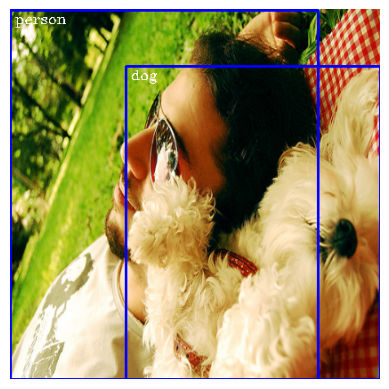

In [61]:
from matplotlib import pyplot as plt
image,target = train_ds[5]
print(image.shape,type(image))
print(target)
boxes = np.array(target['box']).astype(np.int32)
print(boxes)
labels = np.array(target['label'])
for i,box in enumerate(boxes):
    cv2.rectangle(image,box,(0,0,255),2)
    cv2.putText(image,idx_to_class[labels[i]],(box[0]+5,box[1]+15),
                cv2.FONT_HERSHEY_COMPLEX ,0.5,(111,120,44),1,cv2.LINE_AA)
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

torch.Size([4, 3, 416, 416]) 4
tensor([[ 0.5140,  0.5640,  0.5160,  0.8720, 14.0000]]) <class 'torch.Tensor'>


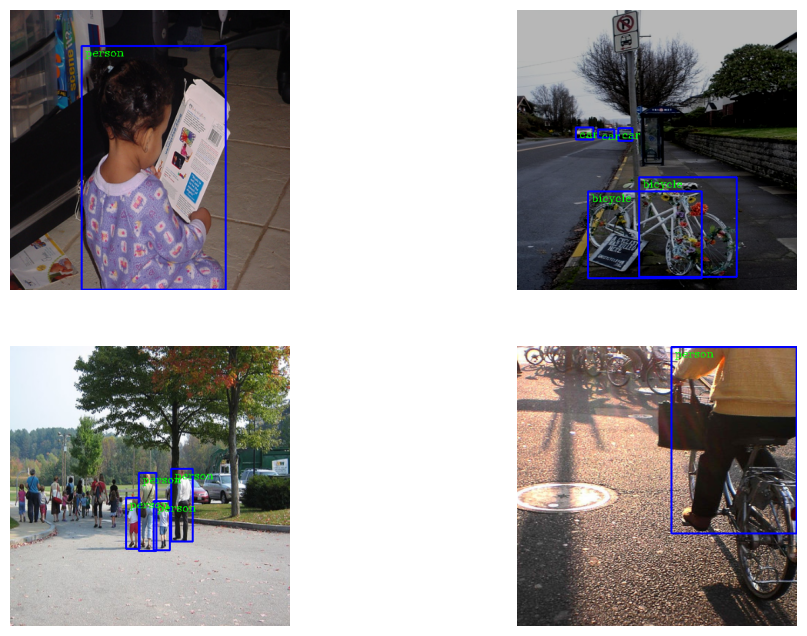

In [63]:
imgs,labels = next(iter(train_dl))
print(imgs.shape,len(labels))
print(labels[0],type(labels[0]))

plt.figure(figsize=(12,8))
for j,data in enumerate(zip(imgs[0:4],labels[0:4])):
    image,label = data
    image = image.numpy().transpose(1,2,0).copy()
    
    box = [(np.array(l)[:4]*416).astype(np.int32) for l in label]
    classes = [(np.array(l)[4]).astype(np.int32) for l in label]
    box_s = []
    for b in box:
        b[:2] = b[:2] - b[2:4]//2
        b[2:4] = b[:2] + b[2:4]
        box_s.append(np.array(b).astype(np.int32))
    
    for i,b in enumerate(box_s):
        cv2.rectangle(image, (b[0],b[1]),(b[2],b[3]), (0,0,255), 2)
        cv2.putText(image,idx_to_class[classes[i]],(b[0]+5,b[1]+15),
                    cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)
    plt.subplot(2,2,j+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

## model

In [64]:
import math
from collections import OrderedDict

class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes):
        super(BasicBlock, self).__init__()
        self.conv1  = nn.Conv2d(inplanes, planes[0], kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1    = nn.BatchNorm2d(planes[0])
        self.relu1  = nn.LeakyReLU(0.1)
        
        self.conv2  = nn.Conv2d(planes[0], planes[1], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2    = nn.BatchNorm2d(planes[1])
        self.relu2  = nn.LeakyReLU(0.1)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out += residual
        return out

class DarkNet(nn.Module):
    def __init__(self, layers):
        super(DarkNet, self).__init__()
        self.inplanes = 32
        # 416,416,3 -> 416,416,32
        self.conv1  = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1    = nn.BatchNorm2d(self.inplanes)
        self.relu1  = nn.LeakyReLU(0.1)

        # 416,416,32 -> 208,208,64
        self.layer1 = self._make_layer([32, 64], layers[0])
        # 208,208,64 -> 104,104,128
        self.layer2 = self._make_layer([64, 128], layers[1])
        # 104,104,128 -> 52,52,256
        self.layer3 = self._make_layer([128, 256], layers[2])
        # 52,52,256 -> 26,26,512
        self.layer4 = self._make_layer([256, 512], layers[3])
        # 26,26,512 -> 13,13,1024
        self.layer5 = self._make_layer([512, 1024], layers[4])

        self.layers_out_filters = [64, 128, 256, 512, 1024]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, planes, blocks):
        layers = []
        layers.append(("ds_conv", nn.Conv2d(self.inplanes, planes[1], kernel_size=3, stride=2, padding=1, bias=False)))
        layers.append(("ds_bn", nn.BatchNorm2d(planes[1])))
        layers.append(("ds_relu", nn.LeakyReLU(0.1)))
        self.inplanes = planes[1]
        for i in range(0, blocks):
            layers.append(("residual_{}".format(i), BasicBlock(self.inplanes, planes)))
        return nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        out3 = self.layer3(x)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)

        return out3, out4, out5

def darknet53():
    model = DarkNet([1, 2, 8, 8, 4])
    return model

In [65]:
def conv2d(filter_in, filter_out, kernel_size):
    pad = (kernel_size - 1) // 2 if kernel_size else 0
    return nn.Sequential(OrderedDict([
        ("conv", nn.Conv2d(filter_in, filter_out, kernel_size=kernel_size, stride=1, padding=pad, bias=False)),
        ("bn", nn.BatchNorm2d(filter_out)),
        ("relu", nn.LeakyReLU(0.1)),
    ]))

def make_last_layers(filters_list, in_filters, out_filter):
    m = nn.Sequential(
        conv2d(in_filters, filters_list[0], 1),
        conv2d(filters_list[0], filters_list[1], 3),
        conv2d(filters_list[1], filters_list[0], 1),
        conv2d(filters_list[0], filters_list[1], 3),
        conv2d(filters_list[1], filters_list[0], 1),
        conv2d(filters_list[0], filters_list[1], 3),
        nn.Conv2d(filters_list[1], out_filter, kernel_size=1, stride=1, padding=0, bias=True)
    )
    return m

class YoloBody(nn.Module):
    def __init__(self, anchors_mask, num_classes, pretrained = False):
        super(YoloBody, self).__init__()
   
        #   52,52,256
        #   26,26,512
        #   13,13,1024
        self.backbone = darknet53()
        if pretrained:
            self.backbone.load_state_dict(torch.load("model_data/darknet53_backbone_weights.pth"))

        #---------------------------------------------------#
        #   out_filters : [64, 128, 256, 512, 1024]
        #---------------------------------------------------#
        out_filters = self.backbone.layers_out_filters

        #   final_out_filter0 = final_out_filter1 = final_out_filter2 = 75
        self.last_layer0            = make_last_layers([512, 1024], out_filters[-1], len(anchors_mask[0]) * (num_classes + 5))

        self.last_layer1_conv       = conv2d(512, 256, 1)
        self.last_layer1_upsample   = nn.Upsample(scale_factor=2, mode='nearest')
        self.last_layer1            = make_last_layers([256, 512], out_filters[-2] + 256, len(anchors_mask[1]) * (num_classes + 5))

        self.last_layer2_conv       = conv2d(256, 128, 1)
        self.last_layer2_upsample   = nn.Upsample(scale_factor=2, mode='nearest')
        self.last_layer2            = make_last_layers([128, 256], out_filters[-3] + 128, len(anchors_mask[2]) * (num_classes + 5))

    def forward(self, x):

        #   52,52,256；26,26,512；13,13,1024
        x2, x1, x0 = self.backbone(x)

       
        #   out0 = (batch_size,255,13,13)
        # 13,13,1024 -> 13,13,512 -> 13,13,1024 -> 13,13,512 -> 13,13,1024 -> 13,13,512
        out0_branch = self.last_layer0[:5](x0)
        out0        = self.last_layer0[5:](out0_branch)

        # 13,13,512 -> 13,13,256 -> 26,26,256
        x1_in = self.last_layer1_conv(out0_branch)
        x1_in = self.last_layer1_upsample(x1_in)

        # 26,26,256 + 26,26,512 -> 26,26,768
        x1_in = torch.cat([x1_in, x1], 1)
       
        #   out1 = (batch_size,255,26,26)
        # 26,26,768 -> 26,26,256 -> 26,26,512 -> 26,26,256 -> 26,26,512 -> 26,26,256
        out1_branch = self.last_layer1[:5](x1_in)
        out1        = self.last_layer1[5:](out1_branch)

        # 26,26,256 -> 26,26,128 -> 52,52,128
        x2_in = self.last_layer2_conv(out1_branch)
        x2_in = self.last_layer2_upsample(x2_in)

        # 52,52,128 + 52,52,256 -> 52,52,384
        x2_in = torch.cat([x2_in, x2], 1)

        #   out3 = (batch_size,255,52,52)
        # 52,52,384 -> 52,52,128 -> 52,52,256 -> 52,52,128 -> 52,52,256 -> 52,52,128
        out2 = self.last_layer2(x2_in)
        return out0, out1, out2

In [66]:
anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
num_class = len(name_class)
model = YoloBody(anchor_mask,num_class)#.to(device)

# test
inputs = torch.ones((4,3,416,416))#.to(device)
outs = model(inputs)
for out in outs:
    print(out.shape)

torch.Size([4, 75, 13, 13])
torch.Size([4, 75, 26, 26])
torch.Size([4, 75, 52, 52])


In [68]:
import torch
torch.cuda.empty_cache()

In [ ]:
model_path = '/kaggle/input/yolo-weights/yolo_weights.pth'
model_path_our = '/kaggle/input/yolo-weights/yolo_weights.pth'
model_dict     = model.state_dict()
pretrained_dict= torch.load(model_path_our, map_location = device)
load_key, no_load_key, temp_dict = [], [], {}
for k, v in pretrained_dict.items():
    if k in model_dict.keys() and np.shape(model_dict[k]) == np.shape(v):
        temp_dict[k] = v
        load_key.append(k)
    else:
        no_load_key.append(k)
model_dict.update(temp_dict)
model.load_state_dict(model_dict)

In [ ]:
anchors = [10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326]
anchors = np.array(anchors).reshape(-1,2)
anchors

## Yolo loss

In [ ]:
class YOLOLoss(nn.Module):
    def __init__(self, anchors, num_classes, input_shape, cuda, anchors_mask=None):
        super(YOLOLoss, self).__init__()

        if anchors_mask is None:
            anchors_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
        self.anchors        = anchors
        self.num_classes    = num_classes
        self.bbox_attrs     = 5 + num_classes
        self.input_shape    = input_shape
        self.anchors_mask   = anchors_mask

        self.giou           = True
        self.balance        = [0.4, 1.0, 4]
        self.box_ratio      = 0.05
        self.obj_ratio      = 5 * (input_shape[0] * input_shape[1]) / (416 ** 2)
        self.cls_ratio      = 1 * (num_classes / 80)

        self.ignore_threshold = 0.5
        self.cuda           = cuda

    def clip_by_tensor(self, t, t_min, t_max):
        t = t.float()
        result = (t >= t_min).float() * t + (t < t_min).float() * t_min
        result = (result <= t_max).float() * result + (result > t_max).float() * t_max
        return result

    def MSELoss(self, pred, target):
        return torch.pow(pred - target, 2)

    def BCELoss(self, pred, target):
        epsilon = 1e-7
        pred    = self.clip_by_tensor(pred, epsilon, 1.0 - epsilon)
        output  = - target * torch.log(pred) - (1.0 - target) * torch.log(1.0 - pred)
        return output

    def box_giou(self, b1, b2):
    
        b1_xy       = b1[..., :2]
        b1_wh       = b1[..., 2:4]
        b1_wh_half  = b1_wh/2.
        b1_mins     = b1_xy - b1_wh_half
        b1_maxes    = b1_xy + b1_wh_half
        b2_xy       = b2[..., :2]
        b2_wh       = b2[..., 2:4]
        b2_wh_half  = b2_wh/2.
        b2_mins     = b2_xy - b2_wh_half
        b2_maxes    = b2_xy + b2_wh_half

        intersect_mins  = torch.max(b1_mins, b2_mins)
        intersect_maxes = torch.min(b1_maxes, b2_maxes)
        intersect_wh    = torch.max(intersect_maxes - intersect_mins, torch.zeros_like(intersect_maxes))
        intersect_area  = intersect_wh[..., 0] * intersect_wh[..., 1]
        b1_area         = b1_wh[..., 0] * b1_wh[..., 1]
        b2_area         = b2_wh[..., 0] * b2_wh[..., 1]
        union_area      = b1_area + b2_area - intersect_area
        iou             = intersect_area / union_area

        enclose_mins    = torch.min(b1_mins, b2_mins)
        enclose_maxes   = torch.max(b1_maxes, b2_maxes)
        enclose_wh      = torch.max(enclose_maxes - enclose_mins, torch.zeros_like(intersect_maxes))
    
        enclose_area    = enclose_wh[..., 0] * enclose_wh[..., 1]
        giou            = iou - (enclose_area - union_area) / enclose_area
        
        return giou
        
    def forward(self, l, input, targets=None):
  
        bs      = input.size(0)
        in_w    = input.size(2)
        in_h    = input.size(3)

        stride_h = self.input_shape[1] / in_h
        stride_w = self.input_shape[0] / in_w

        # scaled_anchors
        scaled_anchors  = [(a_w / stride_w, a_h / stride_h) for a_w, a_h in self.anchors]

        #   bs, 3*(5+num_classes), 13, 13 => batch_size, 3, 13, 13, 5 + num_classes
        #   batch_size, 3, 26, 26, 5 + num_classes
        #   batch_size, 3, 52, 52, 5 + num_classes
        prediction = input.view(bs, len(self.anchors_mask[l]), self.bbox_attrs, in_w, in_h).permute(0, 1, 3, 4, 2).contiguous()
        
        x = torch.sigmoid(prediction[..., 0])
        y = torch.sigmoid(prediction[..., 1])
        w = prediction[..., 2]
        h = prediction[..., 3]
        conf = torch.sigmoid(prediction[..., 4])
        pred_cls = torch.sigmoid(prediction[..., 5:])

        y_true, noobj_mask, box_loss_scale = self.get_target(l, targets, scaled_anchors, in_w, in_h)

        noobj_mask, pred_boxes = self.get_ignore(l, x, y, h, w, targets, scaled_anchors, in_w, in_h, noobj_mask)

        if self.cuda:
            y_true          = y_true.type_as(x)
            noobj_mask      = noobj_mask.type_as(x)
            box_loss_scale  = box_loss_scale.type_as(x)

        box_loss_scale = 2 - box_loss_scale
            
        loss        = 0
        obj_mask    = y_true[..., 4] == 1
        n           = torch.sum(obj_mask)
        if n != 0:
            if self.giou:
                giou        = self.box_giou(pred_boxes, y_true[..., :4]).type_as(x)
                loss_loc    = torch.mean((1 - giou)[obj_mask])
            else:
             
                loss_x      = torch.mean(self.BCELoss(x[obj_mask], y_true[..., 0][obj_mask]) * box_loss_scale[obj_mask])
                loss_y      = torch.mean(self.BCELoss(y[obj_mask], y_true[..., 1][obj_mask]) * box_loss_scale[obj_mask])
     
                #  loss
                loss_w      = torch.mean(self.MSELoss(w[obj_mask], y_true[..., 2][obj_mask]) * box_loss_scale[obj_mask])
                loss_h      = torch.mean(self.MSELoss(h[obj_mask], y_true[..., 3][obj_mask]) * box_loss_scale[obj_mask])
                loss_loc    = (loss_x + loss_y + loss_h + loss_w) * 0.1

            loss_cls    = torch.mean(self.BCELoss(pred_cls[obj_mask], y_true[..., 5:][obj_mask]))
            loss        += loss_loc * self.box_ratio + loss_cls * self.cls_ratio

        loss_conf   = torch.mean(self.BCELoss(conf, obj_mask.type_as(conf))[noobj_mask.bool() | obj_mask])
        loss        += loss_conf * self.balance[l] * self.obj_ratio

        return loss

    def calculate_iou(self, _box_a, _box_b):

        b1_x1, b1_x2 = _box_a[:, 0] - _box_a[:, 2] / 2, _box_a[:, 0] + _box_a[:, 2] / 2
        b1_y1, b1_y2 = _box_a[:, 1] - _box_a[:, 3] / 2, _box_a[:, 1] + _box_a[:, 3] / 2

        b2_x1, b2_x2 = _box_b[:, 0] - _box_b[:, 2] / 2, _box_b[:, 0] + _box_b[:, 2] / 2
        b2_y1, b2_y2 = _box_b[:, 1] - _box_b[:, 3] / 2, _box_b[:, 1] + _box_b[:, 3] / 2

        box_a = torch.zeros_like(_box_a)
        box_b = torch.zeros_like(_box_b)
        box_a[:, 0], box_a[:, 1], box_a[:, 2], box_a[:, 3] = b1_x1, b1_y1, b1_x2, b1_y2
        box_b[:, 0], box_b[:, 1], box_b[:, 2], box_b[:, 3] = b2_x1, b2_y1, b2_x2, b2_y2

        A = box_a.size(0)
        B = box_b.size(0)

        max_xy  = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2), box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
        min_xy  = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2), box_b[:, :2].unsqueeze(0).expand(A, B, 2))
        inter   = torch.clamp((max_xy - min_xy), min=0)
        inter   = inter[:, :, 0] * inter[:, :, 1]

        area_a = ((box_a[:, 2]-box_a[:, 0]) * (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
        area_b = ((box_b[:, 2]-box_b[:, 0]) * (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]

        #   IOU
        union = area_a + area_b - inter
        return inter / union  # [A,B]
    
    def get_target(self, l, targets, anchors, in_w, in_h):  # targets
        #targets:list: bs, num_anchors, tensor[5]
        bs              = len(targets)
        noobj_mask      = torch.ones(bs, len(self.anchors_mask[l]), in_w, in_h, requires_grad = False)
        box_loss_scale  = torch.zeros(bs, len(self.anchors_mask[l]), in_w, in_h, requires_grad = False)

        #   batch_size, 3, 13, 13, 5 + num_classes
        y_true          = torch.zeros(bs, len(self.anchors_mask[l]), in_w, in_h, self.bbox_attrs, requires_grad = False)
        for b in range(bs):            
            if len(targets[b])==0:
                continue
            batch_target = torch.zeros_like(targets[b])
  
            batch_target[:, [0,2]] = targets[b][:, [0,2]] * in_w
            batch_target[:, [1,3]] = targets[b][:, [1,3]] * in_h
            batch_target[:, 4] = targets[b][:, 4]
            batch_target = batch_target.cpu()
            
            #   num_true_box, 4
            gt_box          = torch.FloatTensor(torch.cat((torch.zeros((batch_target.size(0), 2)),batch_target[:, 2:4]), 1))
            anchor_shapes   = torch.FloatTensor(torch.cat((torch.zeros((len(anchors), 2)),torch.FloatTensor(anchors)), 1))
            best_ns = torch.argmax(self.calculate_iou(gt_box, anchor_shapes), dim=-1)

            for t, best_n in enumerate(best_ns):
                if best_n not in self.anchors_mask[l]:
                    continue

                k = self.anchors_mask[l].index(best_n)

                i = torch.floor(batch_target[t, 0]).long()
                j = torch.floor(batch_target[t, 1]).long()
             
                c = batch_target[t, 4].long()

                #   noobj_mask
                noobj_mask[b, k, j, i] = 0
                #   tx、ty
                if not self.giou:
                    #   tx、ty
                    y_true[b, k, j, i, 0] = batch_target[t, 0] - i.float()
                    y_true[b, k, j, i, 1] = batch_target[t, 1] - j.float()
                    y_true[b, k, j, i, 2] = math.log(batch_target[t, 2] / anchors[best_n][0])
                    y_true[b, k, j, i, 3] = math.log(batch_target[t, 3] / anchors[best_n][1])
                    y_true[b, k, j, i, 4] = 1
                    y_true[b, k, j, i, c + 5] = 1
                else:
                    y_true[b, k, j, i, 0] = batch_target[t, 0]
                    y_true[b, k, j, i, 1] = batch_target[t, 1]
                    y_true[b, k, j, i, 2] = batch_target[t, 2]
                    y_true[b, k, j, i, 3] = batch_target[t, 3]
                    y_true[b, k, j, i, 4] = 1
                    y_true[b, k, j, i, c + 5] = 1

                box_loss_scale[b, k, j, i] = batch_target[t, 2] * batch_target[t, 3] / in_w / in_h
        return y_true, noobj_mask, box_loss_scale

    def get_ignore(self, l, x, y, h, w, targets, scaled_anchors, in_w, in_h, noobj_mask):
        bs = len(targets)
 
        grid_x = torch.linspace(0, in_w - 1, in_w).repeat(in_h, 1).repeat(
            int(bs * len(self.anchors_mask[l])), 1, 1).view(x.shape).type_as(x)
        grid_y = torch.linspace(0, in_h - 1, in_h).repeat(in_w, 1).t().repeat(
            int(bs * len(self.anchors_mask[l])), 1, 1).view(y.shape).type_as(x)
 
        scaled_anchors_l = np.array(scaled_anchors)[self.anchors_mask[l]]
        anchor_w = torch.Tensor(scaled_anchors_l).index_select(1, torch.LongTensor([0])).type_as(x)
        anchor_h = torch.Tensor(scaled_anchors_l).index_select(1, torch.LongTensor([1])).type_as(x)
        
        anchor_w = anchor_w.repeat(bs, 1).repeat(1, 1, in_h * in_w).view(w.shape)
        anchor_h = anchor_h.repeat(bs, 1).repeat(1, 1, in_h * in_w).view(h.shape)
    
        pred_boxes_x    = torch.unsqueeze(x + grid_x, -1)
        pred_boxes_y    = torch.unsqueeze(y + grid_y, -1)
        pred_boxes_w    = torch.unsqueeze(torch.exp(w) * anchor_w, -1)
        pred_boxes_h    = torch.unsqueeze(torch.exp(h) * anchor_h, -1)
        pred_boxes      = torch.cat([pred_boxes_x, pred_boxes_y, pred_boxes_w, pred_boxes_h], dim = -1)
        
        for b in range(bs):           
            #   pred_boxes_for_ignore      num_anchors, 4 
            pred_boxes_for_ignore = pred_boxes[b].view(-1, 4)
        
            #   gt_box      num_true_box, 4 
            if len(targets[b]) > 0:
                batch_target = torch.zeros_like(targets[b])
                 
                batch_target[:, [0,2]] = targets[b][:, [0,2]] * in_w
                batch_target[:, [1,3]] = targets[b][:, [1,3]] * in_h
                batch_target = batch_target[:, :4].type_as(x)
                
                #   anch_ious       num_true_box, num_anchors 
                anch_ious = self.calculate_iou(batch_target, pred_boxes_for_ignore)
               
                #   anch_ious_max   num_anchors 
                anch_ious_max, _    = torch.max(anch_ious, dim = 0)
                anch_ious_max       = anch_ious_max.view(pred_boxes[b].size()[:3])
                noobj_mask[b][anch_ious_max > self.ignore_threshold] = 0
        return noobj_mask, pred_boxes

In [ ]:
input_shape = (416,416)
yolo_loss = YOLOLoss(anchors, num_class, input_shape, True, anchor_mask).to(device)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.9)

In [ ]:
def model_train(model, optimizer, scheduler, gen, epoch, num_epochs):
    total_loss = 0
    print('Start Train')
    
    pbar = tqdm(enumerate(gen))
    model.train()
    for iteration, batch in pbar:
        images, targets = batch

        images  = images.to(device)
        targets = [target.to(device) for target in targets]
 
        optimizer.zero_grad()
        outputs     = model(images)
        loss_value_all  = 0
        for l in range(len(outputs)):
            loss_item = yolo_loss(l, outputs[l], targets)
            loss_value_all  += loss_item
        
        loss_value_all.backward()
        optimizer.step()
        total_loss += loss_value_all.item()
        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        pbar.set_postfix(**{'total_loss': total_loss / (iteration + 1),  
                            'lr'        : optimizer.param_groups[0]['lr']})
    scheduler.step()

In [ ]:
def model_test(model, gen_val, epoch, num_epochs):
    total_loss = 0
    print('Start Train')
    
    pbar = tqdm(enumerate(gen_val))
    model.eval()
    for iteration, batch in pbar:
        images, targets = batch

        images  = images.to(device)
        targets = [target.to(device) for target in targets]
        
        outputs     = model(images)
        loss_value_all  = 0
        for l in range(len(outputs)):
            loss_item = yolo_loss(l, outputs[l], targets)
            loss_value_all  += loss_item
        
        total_loss += loss_value_all.item()
        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        pbar.set_postfix(**{'total_loss': total_loss / (iteration + 1),  
                            'lr'        : optimizer.param_groups[0]['lr']})

In [ ]:
Epoch = 3
save_period = 5
for epoch in range(Epoch):
    model_train(model, optimizer, scheduler, train_dl, epoch, Epoch)
    if (epoch+1)%save_period == 0:
        torch.save(model.state_dict(), "epoch_{}_weights.pth".format(epoch+1))
        print('save sucess')

In [ ]:
model_test(model,val_dl,0,1)

In [ ]:
imgs,labels = next(iter(val_dl))
print(imgs.shape,len(labels))
print(labels[0],type(labels[0]))

plt.figure(figsize=(12,8))
for j,data in enumerate(zip(imgs[0:4],labels[0:4])):
    image,label = data
    image = image.numpy().transpose(1,2,0).copy()
    
    box = [(np.array(l)[:4]*416).astype(np.int32) for l in label]
    classes = [(np.array(l)[4]).astype(np.int32) for l in label]
    box_s = []
    for b in box:
        b[:2] = b[:2] - b[2:4]//2
        b[2:4] = b[:2] + b[2:4]
        box_s.append(np.array(b).astype(np.int32))
    
    for i,b in enumerate(box_s):
        cv2.rectangle(image, (b[0],b[1]),(b[2],b[3]), (0,0,255), 2)
        cv2.putText(image,idx_to_class[classes[i]],(b[0]+5,b[1]+15),
                    cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)
    plt.subplot(2,2,j+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [ ]:
def decode_box(inputs):
    outputs = []
    for i, input in enumerate(inputs):
        #   batch_size, 255, 13, 13
        #   batch_size, 255, 26, 26
        #   batch_size, 255, 52, 52 
        batch_size      = input.size(0)
        input_height    = input.size(3)
        input_width     = input.size(2)
 
        #   stride_h = stride_w = 32、16、8 
        stride_h = 416 / input_height
        stride_w = 416 / input_width
 
        scaled_anchors = [(anchor_width / stride_w, anchor_height / stride_h) 
                          for anchor_width, anchor_height in anchors[anchor_mask[i]]]
 
        #   batch_size, 3, 13, 13, 85
        #   batch_size, 3, 26, 26, 85
        #   batch_size, 3, 52, 52, 85 
        prediction = input.view(batch_size, len(anchor_mask[i]),
                                25, input_height, input_width).permute(0, 1, 3, 4, 2).contiguous()
 
        x = torch.sigmoid(prediction[..., 0])  
        y = torch.sigmoid(prediction[..., 1])
 
        w = prediction[..., 2]
        h = prediction[..., 3]
 
        conf        = torch.sigmoid(prediction[..., 4])
        pred_cls    = torch.sigmoid(prediction[..., 5:])
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor  = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
 
        #   batch_size,3,13,13 
        grid_x = torch.linspace(0, input_width - 1, input_width).repeat(input_height, 1).repeat(
                        batch_size * 3, 1, 1).view(x.shape).type(FloatTensor)
        grid_y = torch.linspace(0, input_height - 1, input_height).repeat(input_width, 1).t().repeat(
                        batch_size * 3, 1, 1).view(y.shape).type(FloatTensor)
 
        #   batch_size,3,13,13 
        anchor_w = FloatTensor(scaled_anchors).index_select(1, LongTensor([0]))
        anchor_h = FloatTensor(scaled_anchors).index_select(1, LongTensor([1]))
        anchor_w = anchor_w.repeat(batch_size, 1).repeat(1, 1, input_height * input_width).view(w.shape)
        anchor_h = anchor_h.repeat(batch_size, 1).repeat(1, 1, input_height * input_width).view(h.shape)
       
        pred_boxes          = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0]  = x.data + grid_x
        pred_boxes[..., 1]  = y.data + grid_y
        pred_boxes[..., 2]  = torch.exp(w.data) * anchor_w
        pred_boxes[..., 3]  = torch.exp(h.data) * anchor_h
 
        _scale = torch.Tensor([input_width, input_height, input_width, input_height]).type(FloatTensor)
        output = torch.cat((pred_boxes.view(batch_size, -1, 4) / _scale,
                            conf.view(batch_size, -1, 1), pred_cls.view(batch_size, -1, 20)), -1)
        outputs.append(output.data)
    return outputs

In [ ]:
def non_max_suppression(prediction, num_classes, input_shape, image_shape, letterbox_image, conf_thres=0.5, nms_thres=0.4):
    #   prediction  [batch_size, num_anchors, 85] 
    box_corner          = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    for i, image_pred in enumerate(prediction):
        #   class_conf  [num_anchors, 1]    
        #   class_pred  [num_anchors, 1]   
        class_conf, class_pred = torch.max(image_pred[:, 5:5 + num_classes], 1, keepdim=True) 
 
        conf_mask = (image_pred[:, 4] * class_conf[:, 0] >= conf_thres).squeeze()
 
        image_pred = image_pred[conf_mask]
        class_conf = class_conf[conf_mask]
        class_pred = class_pred[conf_mask]
        if not image_pred.size(0):
            continue
 
        #   detections  [num_anchors, 7]
        #  x1, y1, x2, y2, obj_conf, class_conf, class_pred 
        detections = torch.cat((image_pred[:, :5], class_conf.float(), class_pred.float()), 1)
 
        unique_labels = detections[:, -1].cpu().unique()

        if prediction.is_cuda:
            unique_labels = unique_labels.cuda()
            detections = detections.cuda()

        for c in unique_labels: 
            detections_class = detections[detections[:, -1] == c]
 
            keep = nms(
                detections_class[:, :4],
                detections_class[:, 4] * detections_class[:, 5],
                nms_thres )
            max_detections = detections_class[keep]

            output[i] = max_detections if output[i] is None else torch.cat((output[i], max_detections))

        if output[i] is not None:
            output[i]           = output[i].cpu().numpy()
            box_xy, box_wh      = (output[i][:, 0:2] + output[i][:, 2:4])/2, output[i][:, 2:4] - output[i][:, 0:2]
            output[i][:, :4]    = yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape, letterbox_image)
    return output

In [ ]:
def yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape, letterbox_image):
    input_shape = np.array(input_shape)
    image_shape = np.array(image_shape)

    if letterbox_image:
        #   new_shape
        new_shape = np.round(image_shape * np.min(input_shape/image_shape))
        offset  = (input_shape - new_shape)/2./input_shape
        scale   = input_shape/new_shape

        box_yx  = (box_yx - offset) * scale
        box_hw *= scale

    box_mins    = box_xy - (box_wh / 2.)
    box_maxes   = box_xy + (box_wh / 2.)
    boxes  = np.concatenate([box_mins[..., 0:1], box_mins[..., 1:2], box_maxes[..., 0:1], box_maxes[..., 1:2]], axis=-1)
    boxes *= np.concatenate([image_shape, image_shape], axis=-1)
    return boxes

In [ ]:
from torchvision.ops import nms
from torchvision import transforms

imgs,labels = next(iter(val_dl))
imgs = imgs.to(device)
model.eval()
outputs = model(imgs)

outputs = decode_box(outputs)
results = non_max_suppression(torch.cat(outputs, 1), 20, (416,416), 
                        (416,416), False, conf_thres = 0.5, nms_thres = 0.3)

print(len(results),type(results),type(results[0]))
# result[0] xmin,ymin,xmax,ymax,obj_conf,class_conf,class
plt.figure()
for index in range(len(results)):
    image = imgs[index].cpu().numpy().transpose(1,2,0).copy()
    result = results[index]
    if result is None:
        plt.subplot(2,2,index+1)
        plt.imshow(image)
        continue
    top_label   = np.array(result[:, 6], dtype = 'int32')
    top_conf    = result[:, 4] * result[:, 5]
    top_boxes   = result[:, :4]

    for i, c in list(enumerate(top_label)):
        predicted_class = idx_to_class[int(c)]
        box             = top_boxes[i]
        score           = top_conf[i]

        top, left, bottom, right = box

        top     = max(0, np.floor(top).astype('int32'))
        left    = max(0, np.floor(left).astype('int32'))
        bottom  = min(image.shape[1], np.floor(bottom).astype('int32'))
        right   = min(image.shape[0], np.floor(right).astype('int32'))

        label = '{} {:.2f}'.format(predicted_class, score)

        print(label, top, left, bottom, right,type(top))

        cv2.rectangle(image, (top,left),(bottom,right), (0,0,255), 2)
        cv2.putText(image,label,(top+5,left+15),
                    cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),2)
        
    plt.subplot(2,2,index+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()